In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
pixscale = 0.262
# pixscale = 0.454
psfex_dir = '/global/cfs/cdirs/cosmo/work/legacysurvey/dr9k/calib/psfex'

surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9.fits.gz'
# surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-mosaic-dr9.fits.gz'
# surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-90prime-dr9.fits.gz'
# image_path_list = glob.glob(os.path.join(image_dir, '*ooi*.fits.fz'))
ccd = Table(fitsio.read(surveyccd_path, columns=['filter', 'expnum', 'image_filename', 'ccd_cuts', 'fwhm']))

In [5]:
ccd[:1]

image_filename,expnum,filter,fwhm,ccd_cuts
bytes120,int64,bytes1,float32,int64
decam/CP/V4.8.2a/CP20130831/c4d_130831_235507_ooi_g_ls9.fits.fz,229250,g,4.52623,0


In [ ]:
# np.random.seed(681)
# ccd_index_list = np.random.choice(len(ccd), size=10000, replace=False)

# frac_list = []
# for ccd_index in ccd_index_list:
#     image_filename = ccd['image_filename'][ccd_index]
#     psfex_filename = image_filename.replace('.fits.fz', '-psfex.fits')
#     psfex_path = os.path.join(psfex_dir, psfex_filename)
#     data = Table(fitsio.read(psfex_path, ext=1))

#     psf = np.array(data['psf_mask'][0, 0])

#     grid = pixscale * np.linspace(-0.5*(psf.shape[0]-1), 0.5*(psf.shape[0]-1), psf.shape[0])
#     xx, yy = np.meshgrid(grid, grid)
#     radius_grid = np.sqrt(xx**2 + yy**2)

#     mask = radius_grid>3.0
#     frac_list.append(np.sum(np.sum(psf[mask])/np.sum(psf)))
# frac_list = np.array(frac_list)

In [ ]:
frac_list = np.zeros(len(ccd))
fwhm_list = np.zeros(len(ccd))
for ccd_index in range(len(ccd)):
    if ccd_index%1000==0:
        print(ccd_index, len(ccd))
    image_filename = ccd['image_filename'][ccd_index]
    psfex_filename = image_filename.replace('.fits.fz', '-psfex.fits')
    psfex_path = os.path.join(psfex_dir, psfex_filename)
    data = Table(fitsio.read(psfex_path, ext=1))

    psf = np.array(data['psf_mask'][0, 0])

    grid = pixscale * np.linspace(-0.5*(psf.shape[0]-1), 0.5*(psf.shape[0]-1), psf.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)

    mask = radius_grid>3.0
    frac_list[ccd_index] = np.sum(np.sum(psf[mask])/np.sum(psf))
    fwhm_list[ccd_index] = data['psf_fwhm'][0]

In [ ]:
plt.hist(frac_list, 100)
plt.show()

plt.figure(figsize=(7, 6))
plt.plot(ccd['fwhm']*pixscale, frac_list, '.', ms=3.)
plt.xlabel('FWHM (arcsec)')
plt.ylabel('Fraction of flux outside 3 arcsec radius')
plt.grid(alpha=0.5)
plt.show()

plt.figure(figsize=(7, 6))
plt.plot(fwhm_list*pixscale, frac_list, '.', ms=3.)
plt.xlabel('FWHM (arcsec)')
plt.ylabel('Fraction of flux outside 3 arcsec radius')
plt.title('mosaic')
plt.grid(alpha=0.5)
plt.show()

---------
## Check asymmetry

In [ ]:
np.random.seed(681)
# ccd_index_list = np.random.choice(len(ccd), size=1000, replace=False)
ccd_index_list = np.arange(len(ccd))

r_moment_list = np.zeros(len(ccd_index_list))

for index, ccd_index in enumerate(ccd_index_list):
    if index%1000==0:
        print(index, len(ccd))
    image_filename = ccd['image_filename'][ccd_index]
    psfex_filename = image_filename.replace('.fits.fz', '-psfex.fits')
    psfex_path = os.path.join(psfex_dir, psfex_filename)
    data = Table(fitsio.read(psfex_path, ext=1))

    psf = np.array(data['psf_mask'][0, 0])

    grid = pixscale * np.linspace(-0.5*(psf.shape[0]-1), 0.5*(psf.shape[0]-1), psf.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()
    psf = psf/np.sum(psf)
    
    x_moment = np.sum(xx*psf)
    y_moment = np.sum(yy*psf)
    r_moment_list[index] = np.sqrt(x_moment**2 + y_moment**2)

In [6]:
# np.save('psfex/decam_first_moment.npy', r_moment_list)
r_moment_list = np.load('psfex/decam_first_moment.npy')

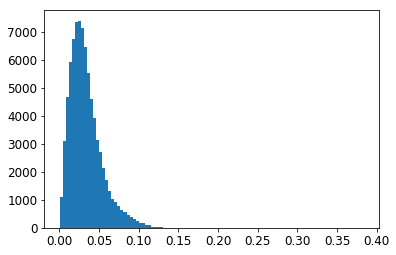

In [7]:
plt.hist(r_moment_list, 100)
plt.show()

In [ ]:
plt.figure(figsize=(7, 6))
plt.plot(r_moment_list, frac_list, '.', ms=3.)
plt.xlabel('First moment (arcsec)')
plt.ylabel('Fraction of flux outside 3 arcsec radius')
plt.title('DECam')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(7, 6))
plt.plot(fwhm_list*pixscale, r_moment_list, '.', ms=3.)
plt.xlabel('FWHM (arcsec)')
plt.ylabel('First moment  (arcsec)')
plt.title('DECam')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
from matplotlib.colors import LogNorm

mask = (r_moment_list)<0.05
print(np.sum(mask))
ccd_index_list_plot = ccd_index_list[mask]
np.random.seed(681)
ccd_index_list_plot = np.random.choice(ccd_index_list_plot, size=10, replace=False)

for ccd_index in ccd_index_list_plot:
    image_filename = ccd['image_filename'][ccd_index]
    psfex_filename = image_filename.replace('.fits.fz', '-psfex.fits')
    psfex_path = os.path.join(psfex_dir, psfex_filename)
    data = Table(fitsio.read(psfex_path, ext=1))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
    psf = np.array(data['psf_mask'][0, 0])
    
    grid = pixscale * np.linspace(-0.5*(psf.shape[0]-1), 0.5*(psf.shape[0]-1), psf.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    mask = radius_grid>3.0
    frac = np.sum(np.sum(psf[mask])/np.sum(psf))

    print('{} expnum={}  1st moment={:.4f}  frac={:.3f}'.format(ccd_index, ccd['expnum'][ccd_index], r_moment_list[ccd_index], frac))

    extent = 0.5*pixscale*(psf.shape[1]*np.array([-1, 1, 0, 0])+psf.shape[0]*np.array([0, 0, -1, 1]))
    im = ax[0].imshow(psf, vmin=1e-3*psf.max(), vmax=psf.max(), cmap='viridis', extent=extent, norm=LogNorm())
    ax[0].grid(alpha=0.5)
    ax[0].set_xlabel('arcsec')
    ax[0].set_ylabel('arcsec')
    fig.colorbar(im, ax=ax[0], shrink=0.75)
    psf = np.array(data['psf_mask'][1, 0])
    im = ax[1].imshow(psf, vmin=1e-3*psf.max(), vmax=psf.max(), cmap='viridis', extent=extent, norm=LogNorm())
    ax[1].grid(alpha=0.5)
    ax[1].set_xlabel('arcsec')
    ax[1].set_ylabel('arcsec')
    fig.colorbar(im, ax=ax[1], shrink=0.75)
    fig.suptitle('{} expnum={}  1st moment={:.4f}  frac={:.3f}'.format(ccd_index, ccd['expnum'][ccd_index], r_moment_list[ccd_index], frac))
    plt.show()

In [ ]:
from matplotlib.colors import LogNorm

mask = (r_moment_list)>0.12
ccd_index_list_plot = ccd_index_list[mask]
ccd_index_list_plot = ccd_index_list_plot[np.argsort(-r_moment_list[ccd_index_list_plot])]

print(np.sum(mask))
for ccd_index in ccd_index_list_plot:
    image_filename = ccd['image_filename'][ccd_index]
    psfex_filename = image_filename.replace('.fits.fz', '-psfex.fits')
    psfex_path = os.path.join(psfex_dir, psfex_filename)
    data = Table(fitsio.read(psfex_path, ext=1))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
    psf = np.array(data['psf_mask'][0, 0])
    
    grid = pixscale * np.linspace(-0.5*(psf.shape[0]-1), 0.5*(psf.shape[0]-1), psf.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    mask = radius_grid>3.0
    frac = np.sum(np.sum(psf[mask])/np.sum(psf))

    print('{} expnum={} {} 1st moment={:.4f}  frac={:.3f}'.format(ccd_index, ccd['expnum'][ccd_index], ccd['filter'][ccd_index], r_moment_list[ccd_index], frac))

    extent = 0.5*pixscale*(psf.shape[1]*np.array([-1, 1, 0, 0])+psf.shape[0]*np.array([0, 0, -1, 1]))
    im = ax[0].imshow(psf, vmin=1e-3*psf.max(), vmax=psf.max(), cmap='viridis', extent=extent, norm=LogNorm())
    ax[0].grid(alpha=0.5)
    ax[0].set_xlabel('arcsec')
    ax[0].set_ylabel('arcsec')
    fig.colorbar(im, ax=ax[0], shrink=0.75)
    psf = np.array(data['psf_mask'][1, 0])
    im = ax[1].imshow(psf, vmin=1e-3*psf.max(), vmax=psf.max(), cmap='viridis', extent=extent, norm=LogNorm())
    ax[1].grid(alpha=0.5)
    ax[1].set_xlabel('arcsec')
    ax[1].set_ylabel('arcsec')
    fig.colorbar(im, ax=ax[1], shrink=0.75)
    fig.suptitle('{} expnum={} {} 1st moment={:.4f}  frac={:.3f}'.format(ccd_index, ccd['expnum'][ccd_index], ccd['filter'][ccd_index], r_moment_list[ccd_index], frac))
    plt.show()

In [ ]:
from matplotlib.colors import LogNorm

ccd_index_list_plot = ccd_index_list[np.argsort(-r_moment_list[ccd_index_list])]
ccd_index_list_plot = ccd_index_list_plot[:400]

print(np.sum(mask))
for index, ccd_index in enumerate(ccd_index_list_plot):
    image_filename = ccd['image_filename'][ccd_index]
    psfex_filename = image_filename.replace('.fits.fz', '-psfex.fits')
    psfex_path = os.path.join(psfex_dir, psfex_filename)
    data = Table(fitsio.read(psfex_path, ext=1))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
    psf = np.array(data['psf_mask'][0, 0])
    
    grid = pixscale * np.linspace(-0.5*(psf.shape[0]-1), 0.5*(psf.shape[0]-1), psf.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    mask = radius_grid>3.0
    frac = np.sum(np.sum(psf[mask])/np.sum(psf))

    print('{}  expnum={}  1st moment={:.4f}  frac={:.3f}'.format(index, ccd['expnum'][ccd_index], r_moment_list[ccd_index], frac))
    
    extent = 0.5*pixscale*(psf.shape[1]*np.array([-1, 1, 0, 0])+psf.shape[0]*np.array([0, 0, -1, 1]))
    im = ax[0].imshow(psf, vmin=1e-3*psf.max(), vmax=psf.max(), cmap='viridis', extent=extent, norm=LogNorm())
    ax[0].grid(alpha=0.5)
    ax[0].set_xlabel('arcsec')
    ax[0].set_ylabel('arcsec')
    fig.colorbar(im, ax=ax[0], shrink=0.75)
    psf = np.array(data['psf_mask'][1, 0])
    im = ax[1].imshow(psf, vmin=1e-3*psf.max(), vmax=psf.max(), cmap='viridis', extent=extent, norm=LogNorm())
    ax[1].grid(alpha=0.5)
    ax[1].set_xlabel('arcsec')
    ax[1].set_ylabel('arcsec')
    fig.colorbar(im, ax=ax[1], shrink=0.75)
    fig.suptitle('{} expnum={}  {}-band  1st_moment={:.4f}  frac={:.3f}'.format(ccd_index, ccd['expnum'][ccd_index], ccd['filter'][ccd_index], r_moment_list[ccd_index], frac))
    plt.savefig('/global/cfs/cdirs/desi/users/rongpu/plots/dr9dev/weird_psf/decam_largest_1st_moment/{}.png'.format(ccd['expnum'][ccd_index]))

In [9]:
ccd_index_list = np.arange(len(ccd))
ccd_index_list_plot = ccd_index_list[np.argsort(-r_moment_list[ccd_index_list])]
ccd_index_list_plot = ccd_index_list_plot[:400]

f = open("/global/cfs/cdirs/desi/users/rongpu/plots/dr9dev/weird_psf/decam_largest_1st_moment.html", "w")
f.write('<html>\n')
f.write('<table>\n')

for ccd_index in ccd_index_list_plot:
    plot_fn1 = 'decam_largest_1st_moment/{}.png'.format(ccd['expnum'][ccd_index])
    f.write('<tr>\n')
    f.write('<td>Exposure {}\n'.format(ccd['expnum'][ccd_index]))
    f.write('<td><a href=\'{}\'><img src=\'{}\' width=\'800\'></a></td>\n'.format(plot_fn1, plot_fn1))
    f.write('</tr>\n')
        
f.write('</table>\n')
f.close()